In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib3
urllib3.disable_warnings()
import warnings
warnings.filterwarnings('ignore')

API_KEY = 'RIWOMQAIJJ40V284'

plt.style.use('seaborn')

In [32]:
def draw_candle(candle):
    x = candle.index[0]
    o = candle.values[0][0]
    h = candle.values[0][1]
    l = candle.values[0][2]
    c = candle.values[0][3]
    t = candle.values[0][10]
    color = 'green' if o <= c else 'red'
    plt.plot([x, x], [h, l], color=color, linewidth=1)
    plt.plot([x, x], [o, c], color=color, linewidth=6)
    plt.annotate(t, xy=[x, h], rotation=90)
    plt.xticks(rotation='vertical')

In [33]:
http = urllib3.PoolManager()
r = http.request('GET', 'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=EUR&to_symbol=USD' +
                 '&outputsize=compact&apikey=' + API_KEY)

In [34]:
df = pd.DataFrame.from_dict(json.loads(r.data)['Time Series FX (Daily)'], orient='index', dtype=float)

df.columns = ['open', 'high', 'low', 'close']
df['sma'] = df.close.rolling(window=10).mean()
df['bull'] = df.close >= df.open
df['trend'] = df.close - df.sma
df['trend'] = df.trend.apply(lambda x: 'UPPER' if x > 0 else 'DOWN' if x < 0 else 'LATERAL')

df['bodysize'] = np.abs(df.close - df.open)

df['bodysize_ma'] = df.bodysize.rolling(window=5).mean()

df.bodysize_ma[1:] = df.bodysize_ma[:-1]

df['bodysize_ind'] = df.bodysize / df.bodysize_ma

df['type'] = df.bodysize_ind.apply(lambda x: 'LONG' if x > 1.3 else 'SHORT' if x < 0.5 else 'NONE')

df['fullsize'] = df.high - df.low
df['bodysize_ind'] = df.bodysize / df.fullsize

df['shade_high'] = df.high - df.close
df['shade_low'] = df.open - df.low

df.loc[df.close < df.open, 'shade_high'] = df.high - df.open
df.loc[df.close < df.open, 'shade_low'] = df.close - df.low

df.loc[(df.type == 'LONG') & ((df.shade_low < df.bodysize * 0.03) | (df.shade_high < df.bodysize * 0.03)),
       'type'] = 'MARIBOZU_LONG'
df.loc[(df.type != 'MARIBOZU_LONG') & ((df.shade_low < df.bodysize * 0.03) | (df.shade_high < df.bodysize * 0.03)),
       'type'] = 'MARIBOZU'

df.loc[(df.shade_low > df.bodysize * 2) & (df.shade_high < df.bodysize * 0.1), 'type'] = 'HAMMER'
df.loc[(df.shade_high > df.bodysize * 2) & (df.shade_low < df.bodysize * 0.1), 'type'] = 'INVERT_HAMMER'
df.loc[(df.shade_high > df.bodysize) & (df.shade_low > df.bodysize), 'type'] = 'SPIN_TOP'
df.loc[df.bodysize_ind < 0.03, 'type'] = 'DOJI'

In [35]:
df[10:11].values[0][10]

'SHORT'

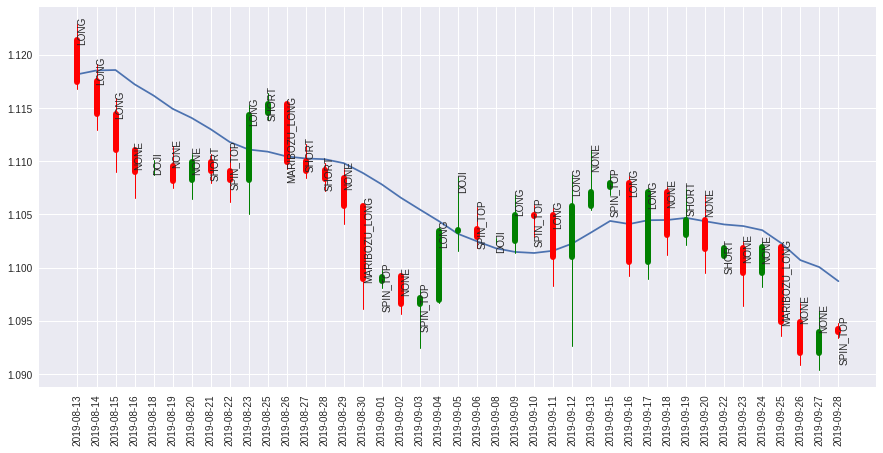

In [36]:
start, end = 60, 101

fig = plt.figure(figsize=(15, 7))
plt.plot(df.sma[start: end])
for i in range(start, end):
    draw_candle(df[i:i+1])

Text(1, 3, 'foo')

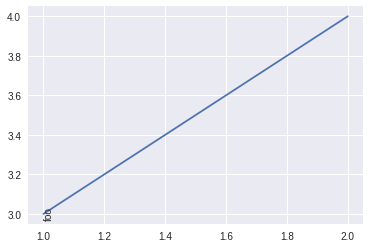

In [37]:
plt.plot([1, 2], [3, 4])
plt.annotate('foo', xy = [1, 3], rotation=90)